In [1]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [2]:
%time
import numpy as np
import pandas as pd
import ants
import os
from matplotlib import pyplot as plt

CPU times: user 2.64 s, sys: 2.52 s, total: 5.16 s
Wall time: 8.88 s


In [7]:
data_latent_vec = np.load('../Data/latent_vecs.npz')
list(data_latent_vec.keys())

['salient_vec_abide',
 'background_vec_abide',
 'vae_vec_abide',
 'salient_vec_sfari',
 'background_vec_sfari',
 'vae_vec_sfari']

In [11]:
from importlib import reload
import pickle
import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models2;reload(make_models2);from make_models2 import *

## LOAD MODEL

In [13]:
%time 
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 27.9 µs


## LOAD DATA

In [18]:
df = pd.read_csv('../Data/ABIDE_legend_S982.csv')
data = np.load('../Data/ABIDE-Anat-64iso-S982.npz')['data']
print(df.shape)
print(data.shape)

(982, 90)
(982, 64, 64, 64)


In [20]:
df.head()

,Unnamed: 0,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,...,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID
0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3


In [27]:
%time
z_embed = z_encoder.predict(data)[2]
s_embed = s_encoder.predict(data)[2]
print(s_embed.shape)

CPU times: user 0 ns, sys: 15 µs, total: 15 µs
Wall time: 30.3 µs
(16,)


In [33]:
latents = pickle.load(open('../Data/embedded_data.pickle','rb'))
list(latents.keys())

['embedding_bg',
 'embedding_sl',
 'embedding_vae',
 'sfari_embedding_vae',
 'sfari_embedding_bg',
 'sfari_embedding_sl',
 'bg_space_abide',
 'sl_space_abide',
 'vae_space_abide',
 'bg_space_sfari',
 'sl_space_sfari',
 'vae_space_sfari',
 'bg_Sspace_sfari',
 'sl_Sspace_sfari',
 'vae_Sspace_sfari',
 'reducer_bg_abide',
 'reducer_sl_abide',
 'reducer_vae_abide',
 'reducer_bg_sfari',
 'reducer_sl_sfari',
 'reducer_vae_sfari']

In [36]:
latents['embedding_sl'].shape

(470, 16)

In [44]:
umap_sl = latents['reducer_sl_abide']

In [42]:
patients = df['DxGroup'].values==1

In [68]:
latents['embedding_sl'].shape

(470, 16)

In [69]:
%%capture
embedding_sl = umap_sl.transform(latents['embedding_sl'])

In [70]:
embedding_sl.shape

(470, 2)

In [74]:
x_loading = embedding_sl[:,0]
y_loading = embedding_sl[:,1]

Text(0.5, 1.0, 'SL SPACE')

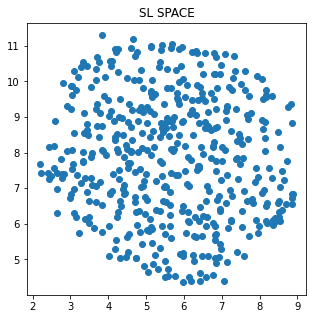

In [121]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_sl[:,0],embedding_sl[:,1])
#plt.scatter(embedding_sl[x_bot_50,0],embedding_sl[x_bot_50,1])
plt.title('SL SPACE')

In [102]:
keys = ['ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']
for key in keys:
    vec = df[key].values[patients]
    e = np.isnan(vec)
    r_x = np.corrcoef(vec[~e],x_loading[~e])[0,1]
    r_y = np.corrcoef(vec[~e],y_loading[~e])[0,1]
    print(f'{key} | X:{r_x:.2f},Y:{r_y:.2f}')

ADOS_Total | X:-0.03,Y:-0.12
ADOS_Comm | X:-0.04,Y:-0.07
ADOS_Social | X:-0.02,Y:-0.12
ADOS_StBeh | X:-0.12,Y:-0.06


In [114]:
x_bot_50 = np.argsort(x_loading)[0:50]
x_top_50 = np.argsort(x_loading)[-50::]

y_bot_50 = np.argsort(y_loading)[0:50]
y_top_50 = np.argsort(y_loading)[-50::]

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_sl[:,0],embedding_sl[:,1])
#plt.scatter(embedding_sl[x_bot_50,0],embedding_sl[x_bot_50,1])
plt.title('SL SPACE')

In [127]:
_max = embedding_sl.max(axis=0)
_min = embedding_sl.min(axis=0)
_mid = embedding_sl.mean(axis=0)

In [141]:
# CALC CORNERS
top = (_mid[0],_max[1])
bottom = (_mid[0],_min[1])
left = (_min[0],_mid[1])
right = (_max[0],_mid[1])

top = np.array(top)
bottom = np.array(bottom)
left = np.array(left)
right = np.array(right)


print(f'top | {top}')
print(f'botom | {bottom}')
print(f'left | {left}')
print(f'right | {right}')

top | [ 5.6382465 11.291993 ]
botom | [5.6382465 4.3504047]
left | [2.1853554 7.838972 ]
right | [8.892335 7.838972]


In [158]:
idx_top50 = np.argsort(np.linalg.norm(embedding_sl-top,axis=1))[0:50]
idx_bottom50 = np.argsort(np.linalg.norm(embedding_sl-bottom,axis=1))[0:50]

idx_left50 = np.argsort(np.linalg.norm(embedding_sl-left,axis=1))[0:50]
idx_right50 = np.argsort(np.linalg.norm(embedding_sl-right,axis=1))[0:50]

Text(0.5, 1.0, 'SL SPACE')

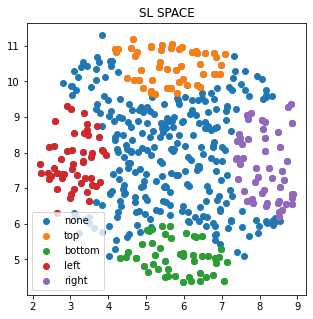

In [162]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_sl[:,0],embedding_sl[:,1])
plt.scatter(embedding_sl[idx_top50,0],embedding_sl[idx_top50,1])
plt.scatter(embedding_sl[idx_bottom50,0],embedding_sl[idx_bottom50,1])
plt.scatter(embedding_sl[idx_left50,0],embedding_sl[idx_left50,1])
plt.scatter(embedding_sl[idx_right50,0],embedding_sl[idx_right50,1])
plt.legend(['none','top','bottom','left','right'])
plt.title('SL SPACE')

In [219]:
invec = idx_top50
def get_corner_brains(invec):
    z = z_encoder.predict(data[invec,:,:,:])[2]
    s = s_encoder.predict(data[invec,:,:,:])[2]
    zeros = np.zeros(s.shape)

    recon = cvae_decoder.predict(np.hstack((z,s)))[:,:,:,:,0]
    twin = cvae_decoder.predict(np.hstack((z,zeros)))[:,:,:,:,0]

    return recon,twin

In [197]:
im = ants.image_read('../Data/anat_temp.nii')
im = im.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [220]:
recon,twin = get_corner_brains(idx_top50)

In [224]:
n = recon.shape[0]
brains_recon = [im.new_image_like(recon[i,:,:,:]) for i in range(n)]
brains_twin = [im.new_image_like(twin[i,:,:,:]) for i in range(n)]

In [225]:
i = 0

In [ ]:
brains_recon[i]

In [228]:
tx = ants.registration(fixed=brains_twin[i],moving=brains_recon[i],type_of_transform='SyN')

In [ ]:
ants.create_jacobian_determinant_image